# Unsupervised outlier detection

This is a template notebook for unsupervised outlier detection.

## How to use the notebook

The following cells:
- specify objective, variables, and data types,
- set up the outlier detection models,
- read dataset,
- present results from the models.

To just see how it works for a toy example, simply run the whole notebook as is.

For your own project, adjust the details about objectives, variables, dataset etc. and then execute all cells in order.
The board "unsupervised.board" will help you with detailed instructions.

# Imports and General Setup
* Requires seaborn and statsmodels installation

In [32]:
import os
import shutil
from distutils.dir_util import copy_tree

import time
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy import stats

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=UserWarning)

from joblib import dump, load

# Project

In [33]:
experiment_name = '{{cookiecutter.use_case_name}}'  # please provide a name for the outlier detection experiment

# Dataset

In [34]:
time_series = False # Specify if the data is time series
path = '{{cookiecutter.data_path}}' # Specify the path of the data, DailyDelhiClimateTrain (time) or WineQT (non time)

if path == 'default example':
    path = 'https://raw.githubusercontent.com/erium/halerium-example-data/main/outlier_detection/WineQT.csv'

if time_series:
    df = pd.read_csv(path, parse_dates=['date'], index_col = 'date')
else:
    df = pd.read_csv(+ path)

num_col = len(df.columns)

out_path = './../out'
isExist = os.path.exists(out_path)
if isExist:
  for root, dirs, files in os.walk(out_path):
      for f in files:
          os.unlink(os.path.join(root, f))
      for d in dirs:
          shutil.rmtree(os.path.join(root, d))
else:
  os.makedirs(out_path)

## Visualising the dataset

In [35]:
df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1138            6.3             0.510         0.13             2.3      0.076   
1139            6.8             0.620         0.08             1.9      0.068   
1140            6.2             0.600         0.08             2.0      0.090   
1141            5.9             0.550         0.10             2.2      0.062   
1142            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1138                 29.0                  40.0  0.99574  3.42       0.75   
1139                 28.0                  38.0  0.99651  3.42       0.82   
1140                 32.0                  44.0  0.99490  3.45       0.58   
1141                 39.0                  51.0  0.99512  3.52       0.76   
1142                 32.0                  44.0  0.99547  3.57       0.71   

      alcohol  quality    Id  
0         9.4        5     0  
1         9.8        5     1  
2         9.8        5     2  
3         9.8        6     3  
4         9.4        5     4  
...       ...      ...   ...  
1138     11.0        6  1592  
1139      9.5        6  1593  
1140     10.5        5  1594  
1141     11.2        6  1595  
1142     10.2        5  1597  

[1143 rows x 13 columns]

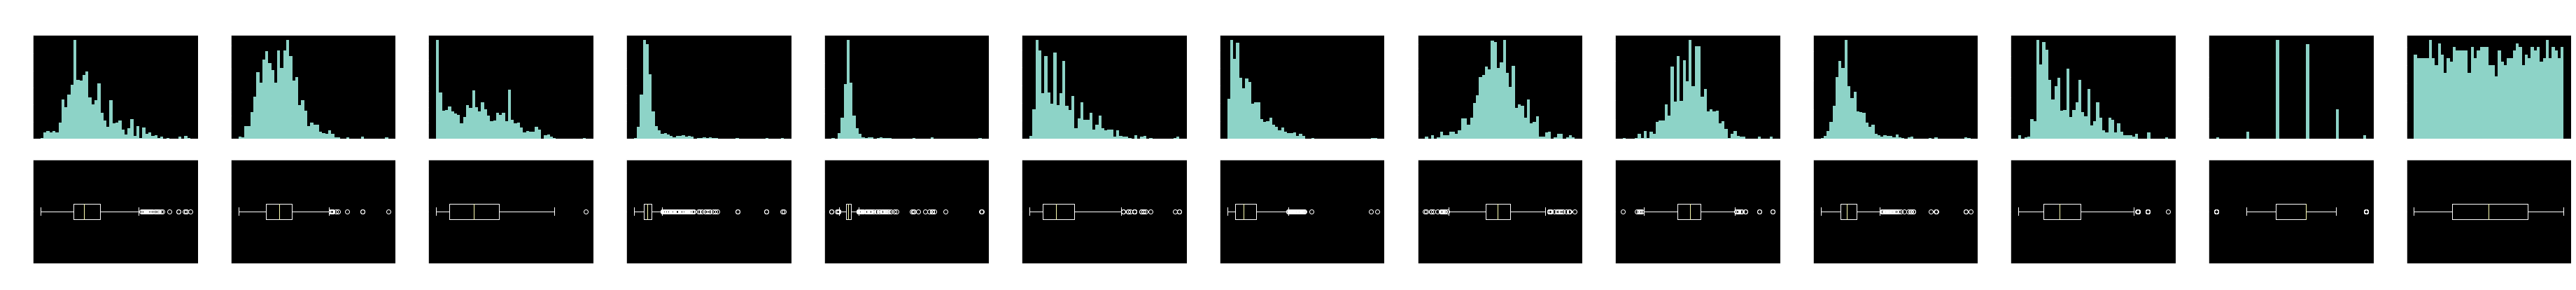

In [36]:
n_bins = 50
plt_v = 3
plt_h = 5
if time_series:
    suptitle = 'Time Series, Frequency, and Box plots of features'
    plt_row = 3
    plt_v *= 3
else:
    suptitle = 'Frequency and Box plots of features'
    plt_row = 2
    plt_v *= 2


if num_col == 1:
    fig, axs = plt.subplots(plt_row, num_col, figsize=(plt_h*num_col, plt_v))
    fig.suptitle(suptitle)
    axs[0].hist(df[df.columns[0]], bins = n_bins)
    axs[0].set_ylabel('Frequency')
    axs[1].boxplot(df[df.columns[0]], vert=False)
    axs[1].set_xlabel(df.columns[0])
    if time_series:
        axs[2].plot(df)
        axs[2].set_xlabel('time')
        axs[2].set_ylabel(df.columns[0])
elif num_col > 1:
    fig, axs = plt.subplots(plt_row, num_col, figsize=(plt_h*num_col, plt_v))
    fig.suptitle(suptitle)
    for i in range(num_col):
        axs[0][i].hist(df[df.columns[i]], bins = n_bins)
        axs[0][i].set_ylabel('Frequency')
        axs[1][i].boxplot(df[df.columns[i]], vert=False)
        axs[1][i].set_xlabel(df.columns[i])
        if time_series:
            axs[2][i].plot(df[df.columns[i]])
            axs[2][i].set_xlabel('time')
            axs[2][i].set_ylabel(df.columns[i])

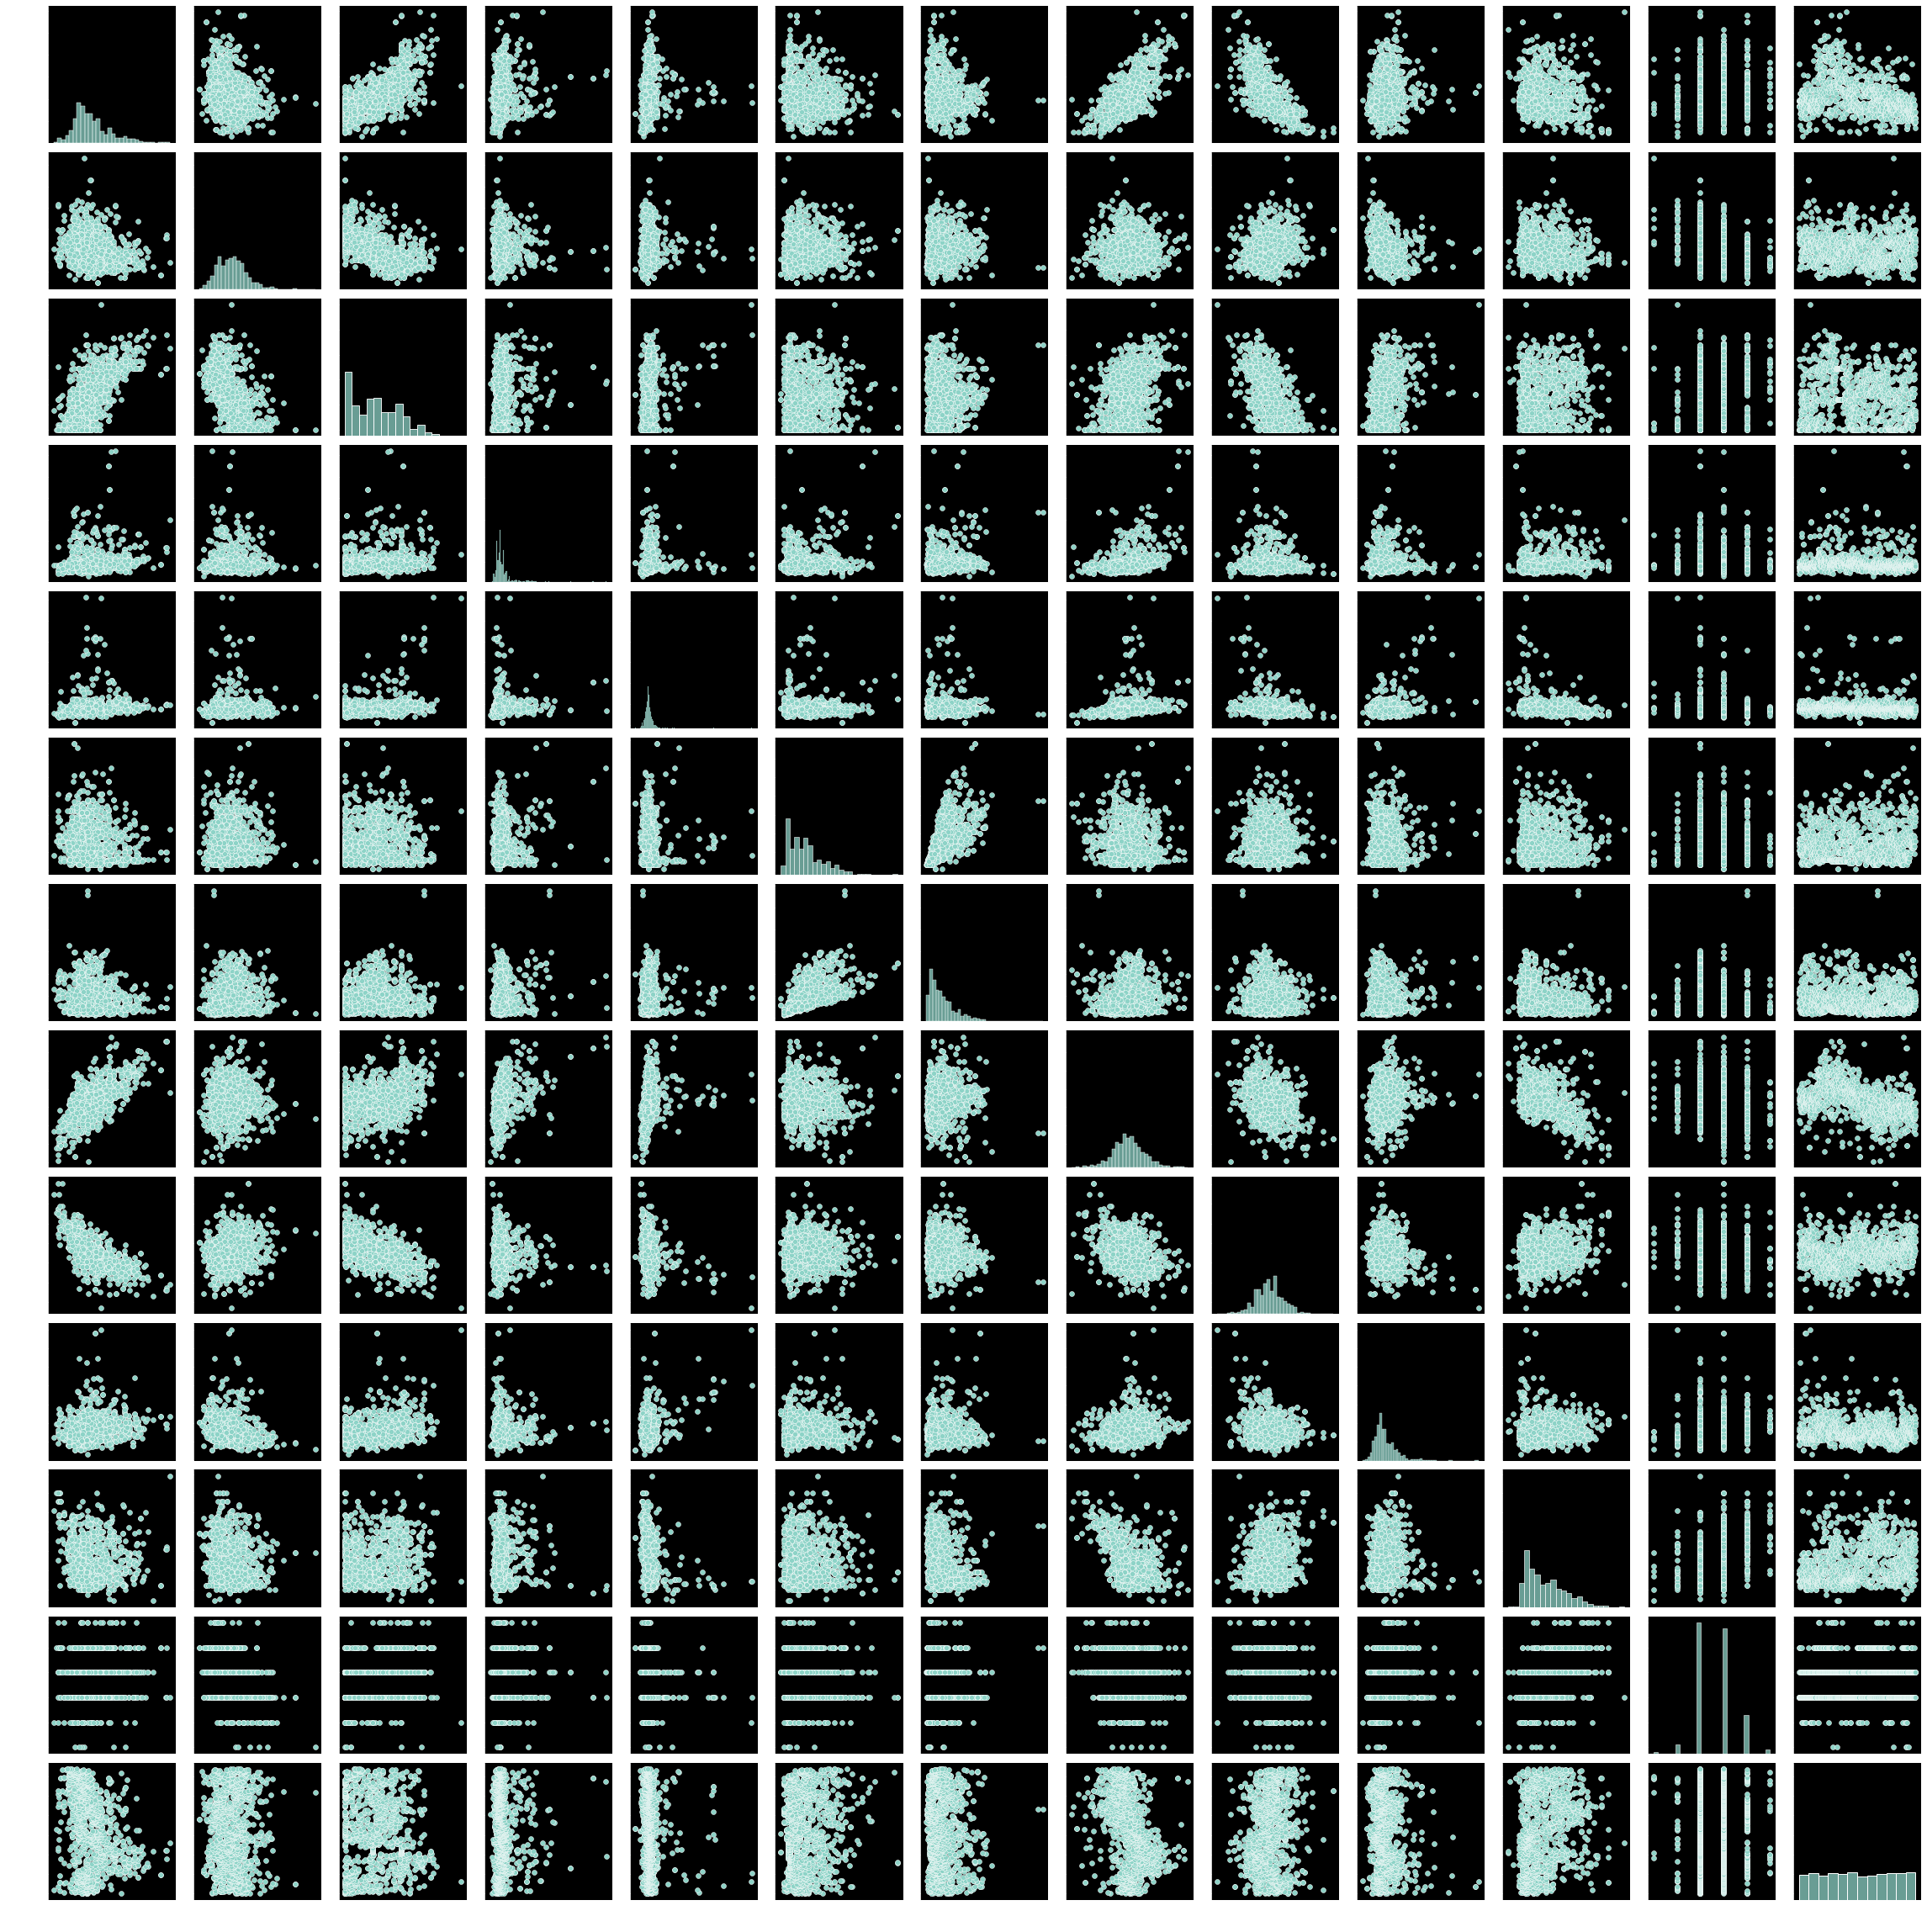

In [37]:
pairplot_hue = None # If you would like to pairplot a discrete variable (may be useful to visually pinpoint collective outliers)
if pairplot_hue:
    sns.pairplot(df, hue = pairplot_hue, palette='hls')
else:
    sns.pairplot(df)

# Models

In [38]:
run_models = ['z_score', 'iqr', 'percentile', 'elliptic', 'svm', 'sgd_svm', 'iso', 'lof'] # Select the outlier detection models to run, note certain models have restrictions on data (eg. clean data for autoencoders)
run_models_data = {}
num_models = len(run_models)

## Metrics

In [39]:
# Metrics to optimise/minimise

# Univariate approaches

In [40]:
univariate_features_to_consider = 'all' # Specify features in list ['x', 'y'] or 'all' to identify outliers

df_uni = df.copy()
if univariate_features_to_consider != 'all':
    df_uni = df_uni[univariate_features_to_consider]

Test for normality

In [41]:
alpha = 1e-3 # You may change this alpha to adjust the strictness of the normal test
normal_variables = []
for column in df_uni.columns:
    k2, p = stats.normaltest(df[column].values)
    if p < alpha:
        normal_variables.append(column)

print(normal_variables)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'Id']


## Z-score
For normally distributed data (only runs on features determined to be sufficiently normally distributed)

In [42]:
num_std = 3 # The number of standard deviations from mean to flag as outlier, 99.7% of data occurs within 3 std of mean in normal distribution

def run_z_score():
    print('Running Z-score')
    print('Threshold std: ' + str(num_std))
    outliers = []
    prediction = list(range(df.shape[0]))
    for variable in normal_variables:
        mean = df[variable].mean()
        std = df[variable].std()
        upper = mean + num_std * std
        lower = mean - num_std * std
        outlier = list(df.index[df[variable] < lower]) + list(df.index[df[variable] > upper])
        outliers += outlier
    outliers = list(set(outliers))
    outliers.sort()
    outliers_index = []
    for outlier in outliers:
        outliers_index.append(df.index.get_loc(outlier))
    outliers = outliers_index

    for p in prediction:
        if p in outliers:
            prediction[p] = -1
        else:
            prediction[p] = 1

    if prediction.count(prediction[0]) == len(prediction): # No outliers detected
        sil = None
        ch = None
        db = None
    else:
        sil = silhouette_score(df, prediction, metric='euclidean')
        ch = calinski_harabasz_score(df, prediction)
        db = davies_bouldin_score(df, prediction)

    print(str(len(outliers)) + ' outliers found')
    return outliers, num_std, [sil, ch, db]

if 'z_score' in run_models:
    run_models_data['z_score'] = [list(run_z_score())]

Running Z-score
Threshold std: 3
102 outliers found


## Interquartile Range (IQR)
For skewed data

In [43]:
num_iqr = 1.5 # The number of interquartile ranges from first and third quantile to flag as outlier, this actually corresponds to a std in normal distribution
#iqr of 1.7 for std 3

def run_iqr():
    print('Running IQR')
    print('Threshold IQR: ' + str(num_iqr))
    print('Corresponds to std of: ' + str(0.675 + num_iqr * 1.35))
    outliers = []
    prediction = list(range(df.shape[0]))
    for column in df_uni.columns:
        percentile25 = df[column].quantile(0.25)
        percentile75 = df[column].quantile(0.75)
        iqr = percentile75 - percentile25
        upper = percentile75 + num_iqr * iqr
        lower = percentile25 - num_iqr * iqr
        outlier = list(df.index[df[column] < lower]) + list(df.index[df[column] > upper])
        outliers += outlier
    outliers = list(set(outliers))
    outliers.sort()
    outliers_index = []
    for outlier in outliers:
        outliers_index.append(df.index.get_loc(outlier))
    outliers = outliers_index

    for p in prediction:
        if p in outliers:
            prediction[p] = -1
        else:
            prediction[p] = 1
    
    if prediction.count(prediction[0]) == len(prediction): # No outliers detected
        sil = None
        ch = None
        db = None
    else:
        sil = silhouette_score(df, prediction, metric='euclidean')
        ch = calinski_harabasz_score(df, prediction)
        db = davies_bouldin_score(df, prediction)

    print(str(len(outliers)) + ' outliers found')
    return outliers, num_iqr, [sil, ch, db]

if 'iqr' in run_models:
    run_models_data['iqr'] = [list(run_iqr())]

Running IQR
Threshold IQR: 1.5
Corresponds to std of: 2.7


309 outliers found


## Percentile
For other distributions

In [44]:
percentile = 0.99

def run_percentile():
    print('Running percentile')
    print('Threshold percentile: ' + str(percentile))
    outliers = []
    prediction = list(range(df.shape[0]))
    for column in df_uni.columns:
        upper = df[column].quantile(percentile)
        lower = df[column].quantile(1 - percentile)
        outlier = list(df.index[df[column] < lower]) + list(df.index[df[column] > upper])
        outliers += outlier
    outliers = list(set(outliers))
    outliers.sort()
    outliers_index = []
    for outlier in outliers:
        outliers_index.append(df.index.get_loc(outlier))
    outliers = outliers_index

    for p in prediction:
        if p in outliers:
            prediction[p] = -1
        else:
            prediction[p] = 1

    if prediction.count(prediction[0]) == len(prediction): # No outliers detected
        sil = None
        ch = None
        db = None
    else:
        sil = silhouette_score(df, prediction, metric='euclidean')
        ch = calinski_harabasz_score(df, prediction)
        db = davies_bouldin_score(df, prediction)

    print(str(len(outliers)) + ' outliers found')
    return outliers, percentile, [sil, ch, db]

if 'percentile' in run_models:
    run_models_data['percentile'] = [list(run_percentile())]

Running percentile
Threshold percentile: 0.99


174 outliers found


## STL
For Time Series

In [45]:
num_std = 3 # Using std to determine residual outliers

def run_stl():
    print('Running STL')
    print('Thresholds: ' + str(num_std))
    outliers = []
    prediction = list(range(df.shape[0]))
    for column in df_uni.columns:
        result = seasonal_decompose(df[column], model='additive') # additive or multiplicative
        fig = result.plot()
        resid = result.resid
        resid = resid.dropna()
        mean = resid.values.mean()
        std = resid.values.std()
        upper = mean + num_std * std
        lower = mean - num_std * std
        outlier = list(resid.index[resid.values < lower]) + list(resid.index[resid.values > upper])
        outliers += outlier
    outliers = list(set(outliers))
    outliers.sort()
    outliers_index = []
    for outlier in outliers:
        outliers_index.append(df.index.get_loc(outlier))
    outliers = outliers_index

    for p in prediction:
        if p in outliers:
            prediction[p] = -1
        else:
            prediction[p] = 1

    if prediction.count(prediction[0]) == len(prediction): # No outliers detected
        sil = None
        ch = None
        db = None
    else:
        sil = silhouette_score(df, prediction, metric='euclidean')
        ch = calinski_harabasz_score(df, prediction)
        db = davies_bouldin_score(df, prediction)

    print(str(len(outliers)) + ' outliers found')
    return outliers, num_std, [sil, ch, db]

if time_series and 'stl' in run_models:
    run_models_data['stl'] = [list(run_stl())]

## ARIMA
For Time Series

In [46]:
def run_arima():
    p = 1 # Lag order: number of lag observations included in the model
    d = 1 # Degree of differencing: Number of times the raw observations are differenced
    q = 1 # Order of moving average: Size of moving average window
    print('Running ARIMA')
    print('Parameters: ' + str({'p': p, 'd':d, 'q': q}))
    outliers = []
    prediction = list(range(df.shape[0]))
    for column in df_uni.columns:
        model = ARIMA(df[column], order=(p, d, q))
        res = model.fit()
        print(res.summary())
        resid = res.resid
        resid_df = pd.DataFrame(resid)
        resid_df.plot()
        mean = resid.values.mean()
        std = resid.values.std()
        upper = mean + num_std * std
        lower = mean - num_std * std
        outlier = list(resid.index[resid.values < lower]) + list(resid.index[resid.values > upper])
        outliers += outlier
    outliers = list(set(outliers))
    outliers.sort()
    outliers_index = []
    for outlier in outliers:
        outliers_index.append(df.index.get_loc(outlier))
    outliers = outliers_index

    for p in prediction:
        if p in outliers:
            prediction[p] = -1
        else:
            prediction[p] = 1

    if prediction.count(prediction[0]) == len(prediction): # No outliers detected
        sil = None
        ch = None
        db = None
    else:
        sil = silhouette_score(df, prediction, metric='euclidean')
        ch = calinski_harabasz_score(df, prediction)
        db = davies_bouldin_score(df, prediction)

    print(str(len(outliers)) + ' outliers found')
    return outliers, (p, d, q), [sil, ch, db]

if time_series and 'arima' in run_models:
    run_models_data['arima'] = [list(run_arima())]

## Univariate approaches results
Note that a point will be classified as an outlier if ANY specified feature is identified as an outlier

features labeled: all
z_score outliers: 102
z_score threshold: 3
iqr outliers: 309
iqr threshold: 1.5
percentile outliers: 174
percentile threshold: 0.99


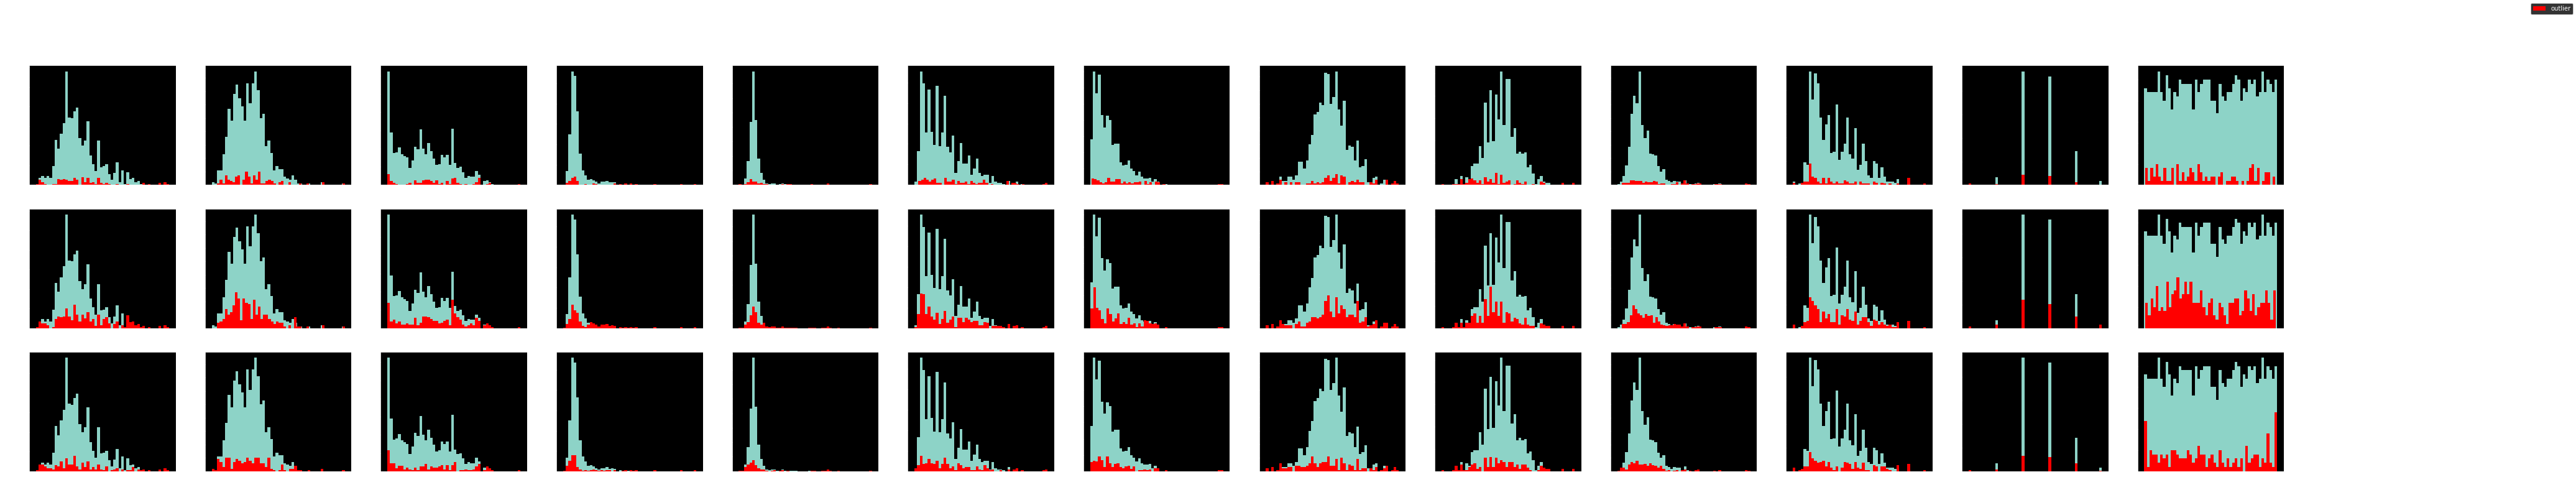

In [47]:
rows = 3
run_models_data = {k:v[0] for (k, v) in run_models_data.items()}
z_score_outliers = run_models_data['z_score'][0]
iqr_outliers = run_models_data['iqr'][0]
percentile_outliers = run_models_data['percentile'][0]
univariate_approaches = ['z_score', 'iqr', 'percentile']
univariate_outliers = [z_score_outliers, iqr_outliers, percentile_outliers]
if time_series:
    stl_outliers = run_models_data['stl'][0]
    arima_outliers = run_models_data['arima'][0]
    univariate_approaches = ['z_score', 'iqr', 'percentile'].extend(['stl', 'arima'])
    univariate_outliers.extend([stl_outliers, arima_outliers])
    rows = 5

print('features labeled: ' + str(univariate_features_to_consider))
print('z_score outliers: ' + str(len(z_score_outliers)))
print('z_score threshold: ' + str(run_models_data['z_score'][1]))
print('iqr outliers: ' + str(len(iqr_outliers)))
print('iqr threshold: ' + str(run_models_data['iqr'][1]))
print('percentile outliers: ' + str(len(percentile_outliers)))
print('percentile threshold: ' + str(run_models_data['percentile'][1]))
if time_series:
    print('stl outliers: ' + str(len(stl_outliers)))
    print('stl threshold: ' + str(run_models_data['stl'][1]))
    print('stl outliers: ' + str(len(arima_outliers)))
    print('stl threshold: ' + str(run_models_data['arima'][1]))

if num_col == 1:
    fig, axs = plt.subplots(rows, num_col, figsize=(plt_h*num_col, plt_v))
    fig.suptitle("Univariate approaches results")
    axs[0].hist(df.iloc[z_score_outliers][df.columns[0]], color='r', bins = n_bins, zorder=2, label='outlier')
    axs[0].hist(df[df.columns[0]], bins = n_bins, zorder=1)
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('z-score outliers')
    axs[1].hist(df.iloc[iqr_outliers][df.columns[0]], color='r', bins = n_bins, zorder=2)
    axs[1].hist(df[df.columns[0]], bins = n_bins, zorder=1)
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('iqr outliers')
    axs[2].hist(df.iloc[percentile_outliers][df.columns[0]], color='r', bins = n_bins, zorder=2)
    axs[2].hist(df[df.columns[0]], bins = n_bins, zorder=1)
    axs[2].set_ylabel('Frequency')
    axs[2].set_xlabel(df.columns[0])
    axs[2].set_title('percentile outliers')
    if time_series:
        axs[3].hist(df.iloc[stl_outliers][df.columns[0]], color='r', bins = n_bins, zorder=2)
        axs[3].hist(df[df.columns[0]], bins = n_bins, zorder=1)
        axs[3].set_ylabel('Frequency')
        axs[3].set_xlabel(df.columns[0])
        axs[3].set_title('stl outliers')
        axs[4].hist(df.iloc[arima_outliers][df.columns[0]], color='r', bins = n_bins, zorder=2)
        axs[4].hist(df[df.columns[0]], bins = n_bins, zorder=1)
        axs[4].set_ylabel('Frequency')
        axs[4].set_xlabel(df.columns[0])
        axs[4].set_title('arima outliers')
elif num_col > 1:
    fig, axs = plt.subplots(rows, num_col, figsize=(plt_h*num_col, 2 * plt_v))
    fig.suptitle("Univariate approaches results")
    for i in range(num_col):
        axs[0][i].hist(df.iloc[z_score_outliers][df.columns[i]], color='r', bins = n_bins, zorder=2, label='outlier')
        axs[0][i].hist(df[df.columns[i]], bins = n_bins, zorder=1)
        axs[0][i].set_ylabel('Frequency')
        axs[0][i].set_title('z-score outliers')
        axs[1][i].hist(df.iloc[iqr_outliers][df.columns[i]], color='r', bins = n_bins, zorder=2)
        axs[1][i].hist(df[df.columns[i]], bins = n_bins, zorder=1)
        axs[1][i].set_ylabel('Frequency')
        axs[1][i].set_title('iqr outliers')
        axs[2][i].hist(df.iloc[percentile_outliers][df.columns[i]], color='r', bins = n_bins, zorder=2)
        axs[2][i].hist(df[df.columns[i]], bins = n_bins, zorder=1)
        axs[2][i].set_ylabel('Frequency')
        axs[2][i].set_xlabel(df.columns[i])
        axs[2][i].set_title('percentile outliers')
        if time_series:
            axs[3][i].hist(df.iloc[stl_outliers][df.columns[i]], color='r', bins = n_bins, zorder=2)
            axs[3][i].hist(df[df.columns[0]], bins = n_bins, zorder=1)
            axs[3][i].set_ylabel('Frequency')
            axs[3][i].set_xlabel(df.columns[0])
            axs[3][i].set_title('stl outliers')
            axs[4][i].hist(df.iloc[arima_outliers][df.columns[i]], color='r', bins = n_bins, zorder=2)
            axs[4][i].hist(df[df.columns[0]], bins = n_bins, zorder=1)
            axs[4][i].set_ylabel('Frequency')
            axs[4][i].set_xlabel(df.columns[0])
            axs[4][i].set_title('arima outliers')
        handles, labels = axs[0][i].get_legend_handles_labels()
    fig.legend(handles, labels)

z_score approach


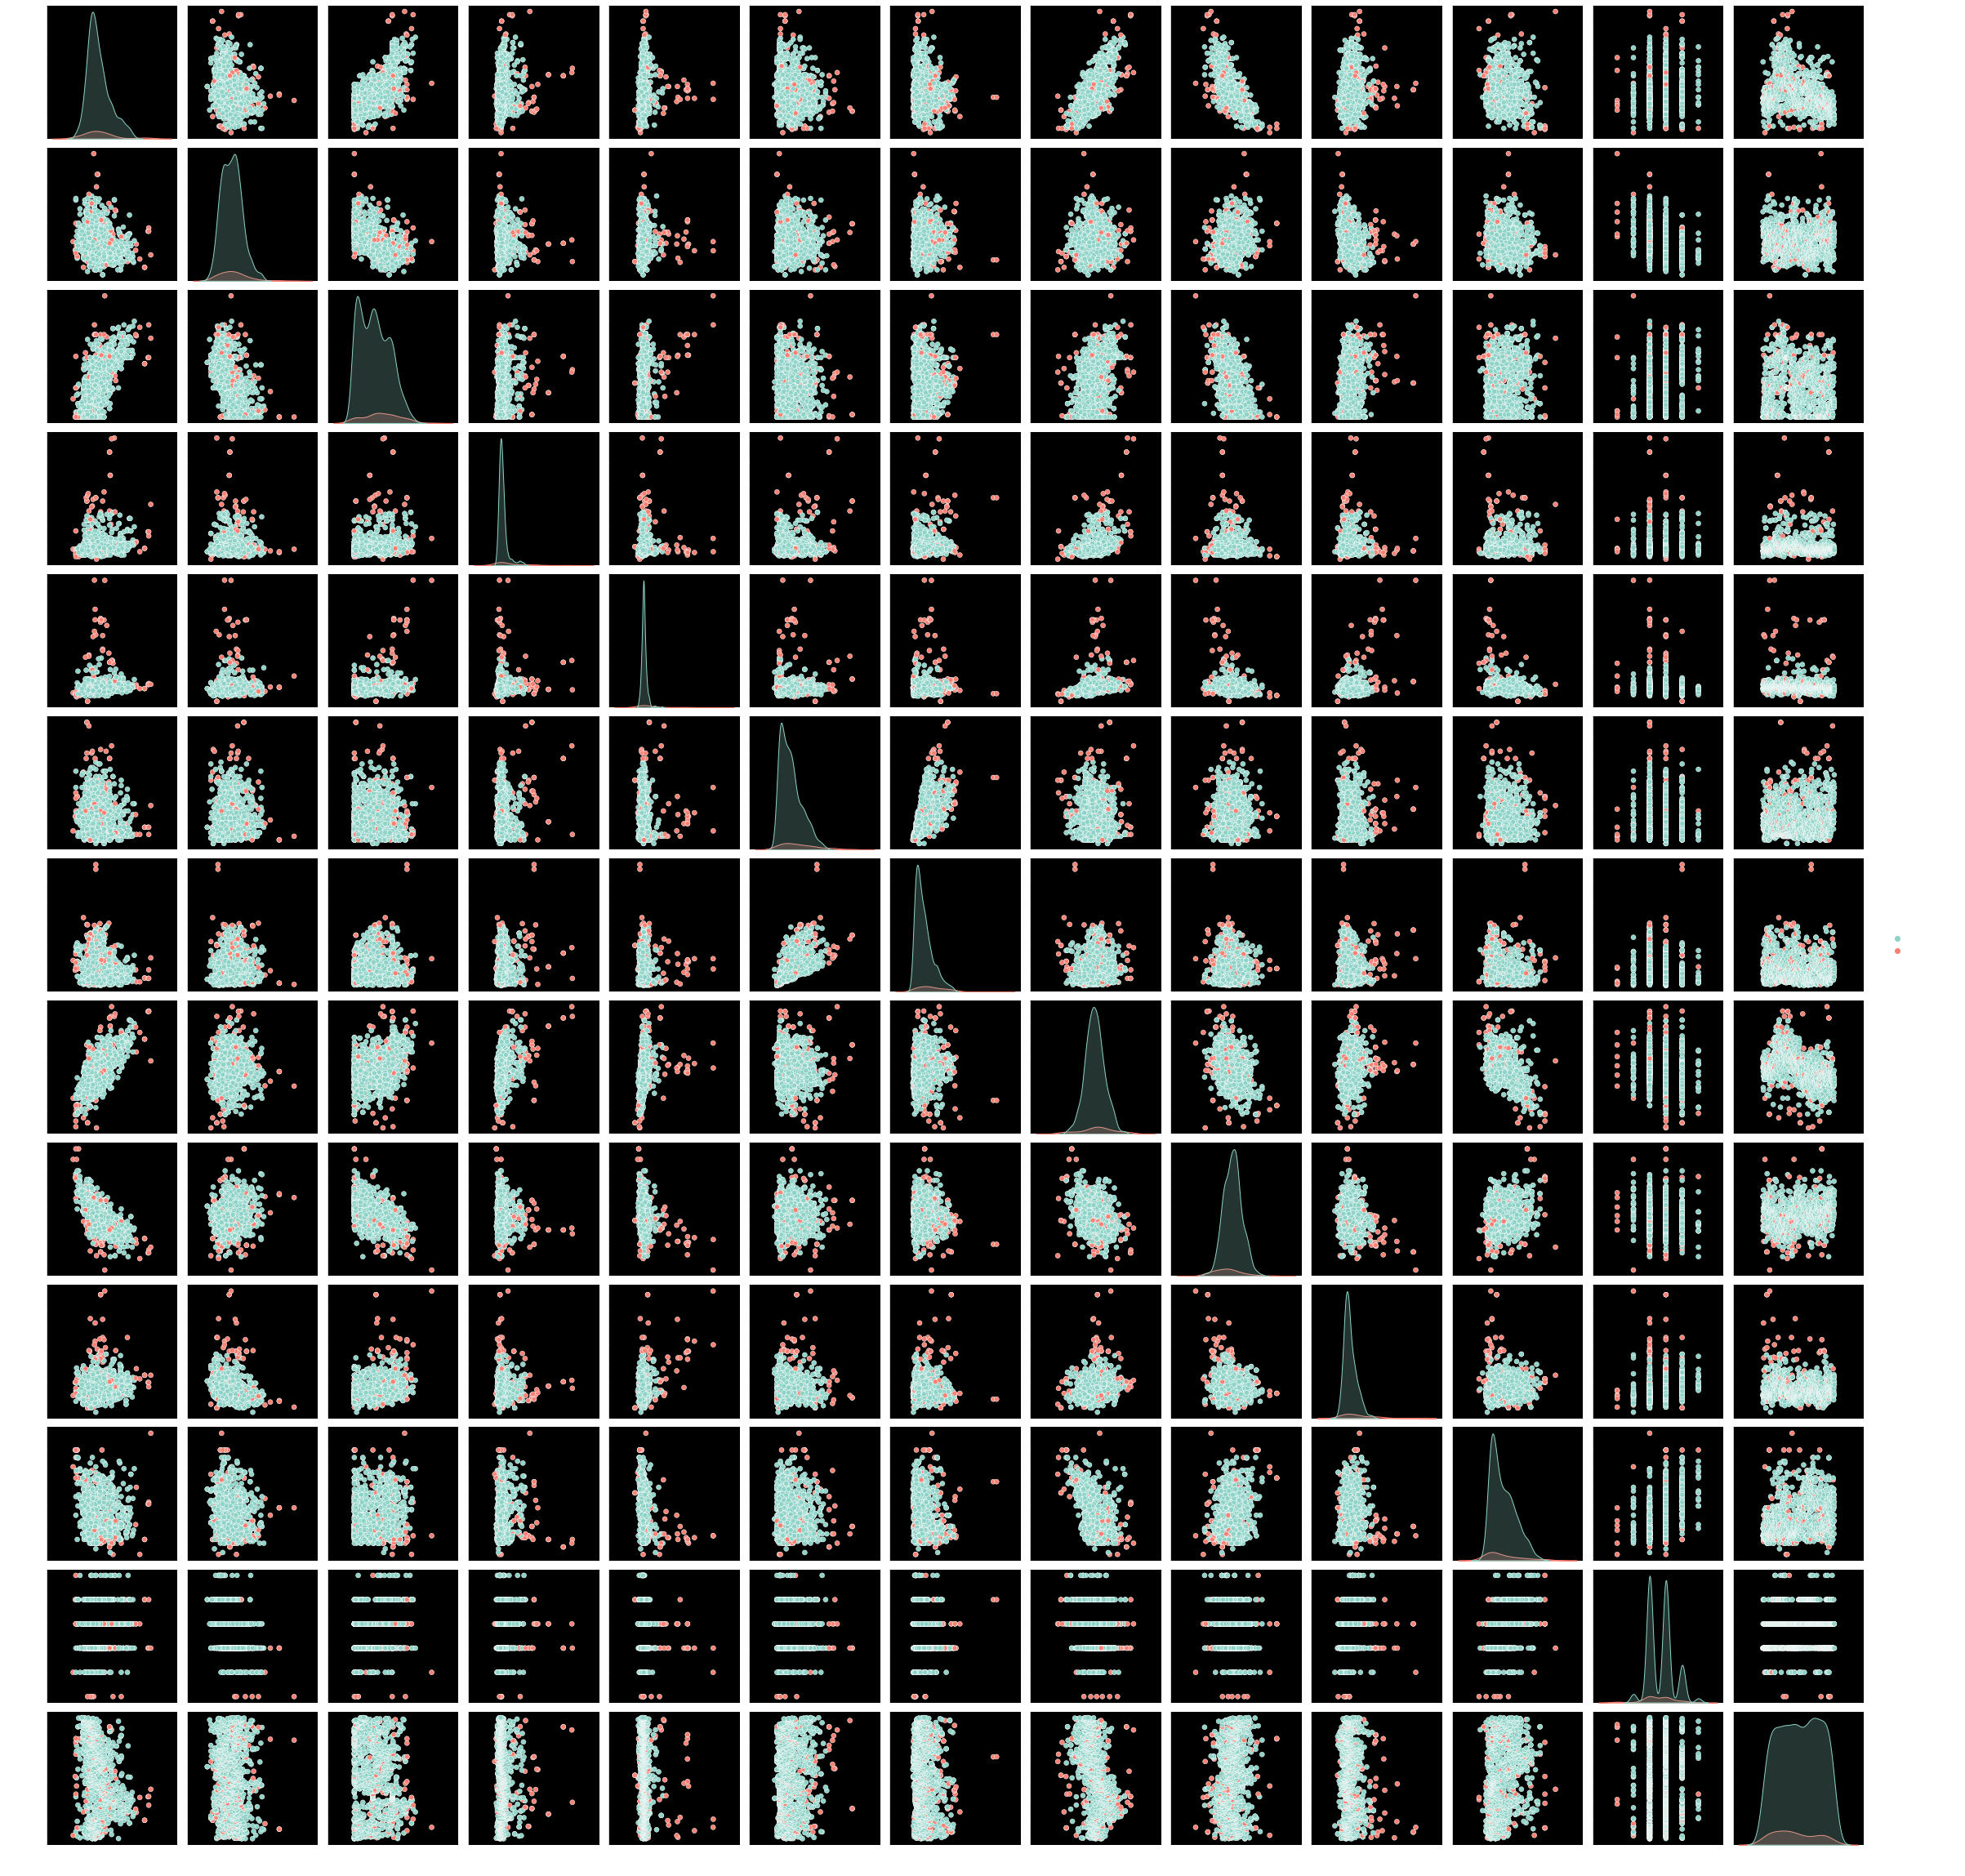

In [48]:
uni_approach_visual = 'z_score' # 'z_score', 'iqr', 'percentile', 'stl', or 'arima'
if uni_approach_visual == 'z_score':
    out = z_score_outliers
elif uni_approach_visual == 'iqr':
    out = iqr_outliers
elif uni_approach_visual == 'percentile':
    out = percentile_outliers
elif uni_approach_visual == 'stl':
    out = stl_outliers
elif uni_approach_visual == 'arima':
    out = arima_outliers

print(uni_approach_visual + ' approach')
df_uni_outlier = df.copy()
df_uni_outlier['outlier'] = 'Non Outlier'
df_uni_outlier.loc[df.index[out], 'outlier'] = 'Outlier'
palette ={"Non Outlier": "C0", "Outlier": "C3"}
sns.pairplot(df_uni_outlier, hue = 'outlier', palette=palette)

# Multivariate approaches

## Elliptic Envelope Covariance

In [49]:
contamination = 0.1 # Proportion of outliers in the dataset (range from (0,0.5]), 0.1 default

def run_elliptic():
    print('Running Elliptic Envelope Covariance')
    outliers = []
    cov = EllipticEnvelope(contamination=contamination).fit(df)
    prediction = cov.predict(df)

    if list(prediction).count(prediction[0]) == len(prediction): # No outliers detected
        sil = None
        ch = None
        db = None
    else:
        sil = silhouette_score(df, prediction, metric='euclidean')
        ch = calinski_harabasz_score(df, prediction)
        db = davies_bouldin_score(df, prediction)

    for i in range(len(prediction)):
        if prediction[i] == -1:
            outliers.append(i)
    print(str(len(outliers)) + ' outliers found')
    return outliers, cov, [sil, ch, db]

if 'elliptic' in run_models:
    run_models_data['elliptic'] = list(run_elliptic()) + [contamination]

Running Elliptic Envelope Covariance


115 outliers found


## One Class SVM
Using Gaussian kernel by default

In [50]:
nu = 0.1 # Proportion of outliers in the dataset (range from (0,1]), 0.5 default

def run_oc_svm():
    print('Running One Class SVM')
    outliers = []
    clf = OneClassSVM(nu = nu).fit(df)
    prediction = clf.predict(df)

    if list(prediction).count(prediction[0]) == len(prediction): # No outliers detected
        sil = None
        ch = None
        db = None
    else:
        sil = silhouette_score(df, prediction, metric='euclidean')
        ch = calinski_harabasz_score(df, prediction)
        db = davies_bouldin_score(df, prediction)

    for i in range(len(prediction)):
        if prediction[i] == -1:
            outliers.append(i)
    print(str(len(outliers)) + ' outliers found')
    return outliers, clf, [sil, ch, db]

if 'svm' in run_models:
    run_models_data['svm'] = list(run_oc_svm()) + [nu]

Running One Class SVM
114 outliers found


## One Class SVM with Stochastic Gradient Descent
With kernel approximation

In [51]:
nu = 0.1 # Upper bound on the fraction of training errors and lower bound of the fraction of support vectors (range from (0,1]), 0.5 default

def run_oc_sgd_svm():
    print('Running One Class SVM with SGD')
    outliers = []
    clf = SGDOneClassSVM(nu = nu).fit(df)
    prediction = clf.predict(df)
    if list(prediction).count(prediction[0]) == len(prediction): # No outliers detected
        sil = None
        ch = None
        db = None
    else:
        sil = silhouette_score(df, prediction, metric='euclidean')
        ch = calinski_harabasz_score(df, prediction)
        db = davies_bouldin_score(df, prediction)

    for i in range(len(prediction)):
        if prediction[i] == -1:
            outliers.append(i)
    print(str(len(outliers)) + ' outliers found')
    return outliers, clf, [sil, ch, db]

if 'sgd_svm' in run_models:
    run_models_data['sgd_svm'] = list(run_oc_sgd_svm()) + [nu]

Running One Class SVM with SGD


3 outliers found


## Isolation Forest

In [52]:
n_estimators = 100 # Number of base estimators in the ensemble
contamination = 0.1 # The proportion of outliers in the dataset (range from (0,0.5]), 0.1 default

def run_iso():
    print('Running Isolation Forest')
    outliers = []
    clf = IsolationForest(n_estimators=n_estimators, contamination=contamination).fit(df)
    prediction = clf.predict(df)

    if list(prediction).count(prediction[0]) == len(prediction): # No outliers detected
        sil = None
        ch = None
        db = None
    else:
        sil = silhouette_score(df, prediction, metric='euclidean')
        ch = calinski_harabasz_score(df, prediction)
        db = davies_bouldin_score(df, prediction)

    for i in range(len(prediction)):
        if prediction[i] == -1:
            outliers.append(i)
    print(str(len(outliers)) + ' outliers found')
    return outliers, clf, [sil, ch, db]

if 'iso' in run_models:
    run_models_data['iso'] = list(run_iso()) + [n_estimators, contamination]

Running Isolation Forest


115 outliers found


## Local Outlier Factor

In [53]:
n_neighbors = 20 # Number of neighbors for kneighbors queries. 20 default
leaf_size = 30 # Affects the speed of construction and query. 30 default
contamination = 0.1 # The proportion of outliers in the dataset (range from (0,0.5]), 0.1 default

def run_lof():
    print('Running Local Outlier Factor')
    outliers = []
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, leaf_size=leaf_size, contamination=contamination)
    clf_predict = LocalOutlierFactor(n_neighbors=n_neighbors, leaf_size=leaf_size, contamination=contamination, novelty=True)
    prediction = clf.fit_predict(df)
    clf_predict.fit(df)

    if list(prediction).count(prediction[0]) == len(prediction): # No outliers detected
        sil = None
        ch = None
        db = None
    else:
        sil = silhouette_score(df, prediction, metric='euclidean')
        ch = calinski_harabasz_score(df, prediction)
        db = davies_bouldin_score(df, prediction)

    for i in range(len(prediction)):
        if prediction[i] == -1:
            outliers.append(i)
    print(str(len(outliers)) + ' outliers found')
    return outliers, prediction, [sil, ch, db], clf_predict

if 'lof' in run_models:
    run_models_data['lof'] = list(run_lof()) + [n_neighbors, leaf_size, contamination]

Running Local Outlier Factor
115 outliers found


# Multivariate approaches result

models used: ['z_score', 'iqr', 'percentile', 'elliptic', 'svm', 'sgd_svm', 'iso', 'lof']
z_score outliers: 102
iqr outliers: 309
percentile outliers: 174
elliptic outliers: 115
svm outliers: 114
sgd_svm outliers: 3
iso outliers: 115
lof outliers: 115


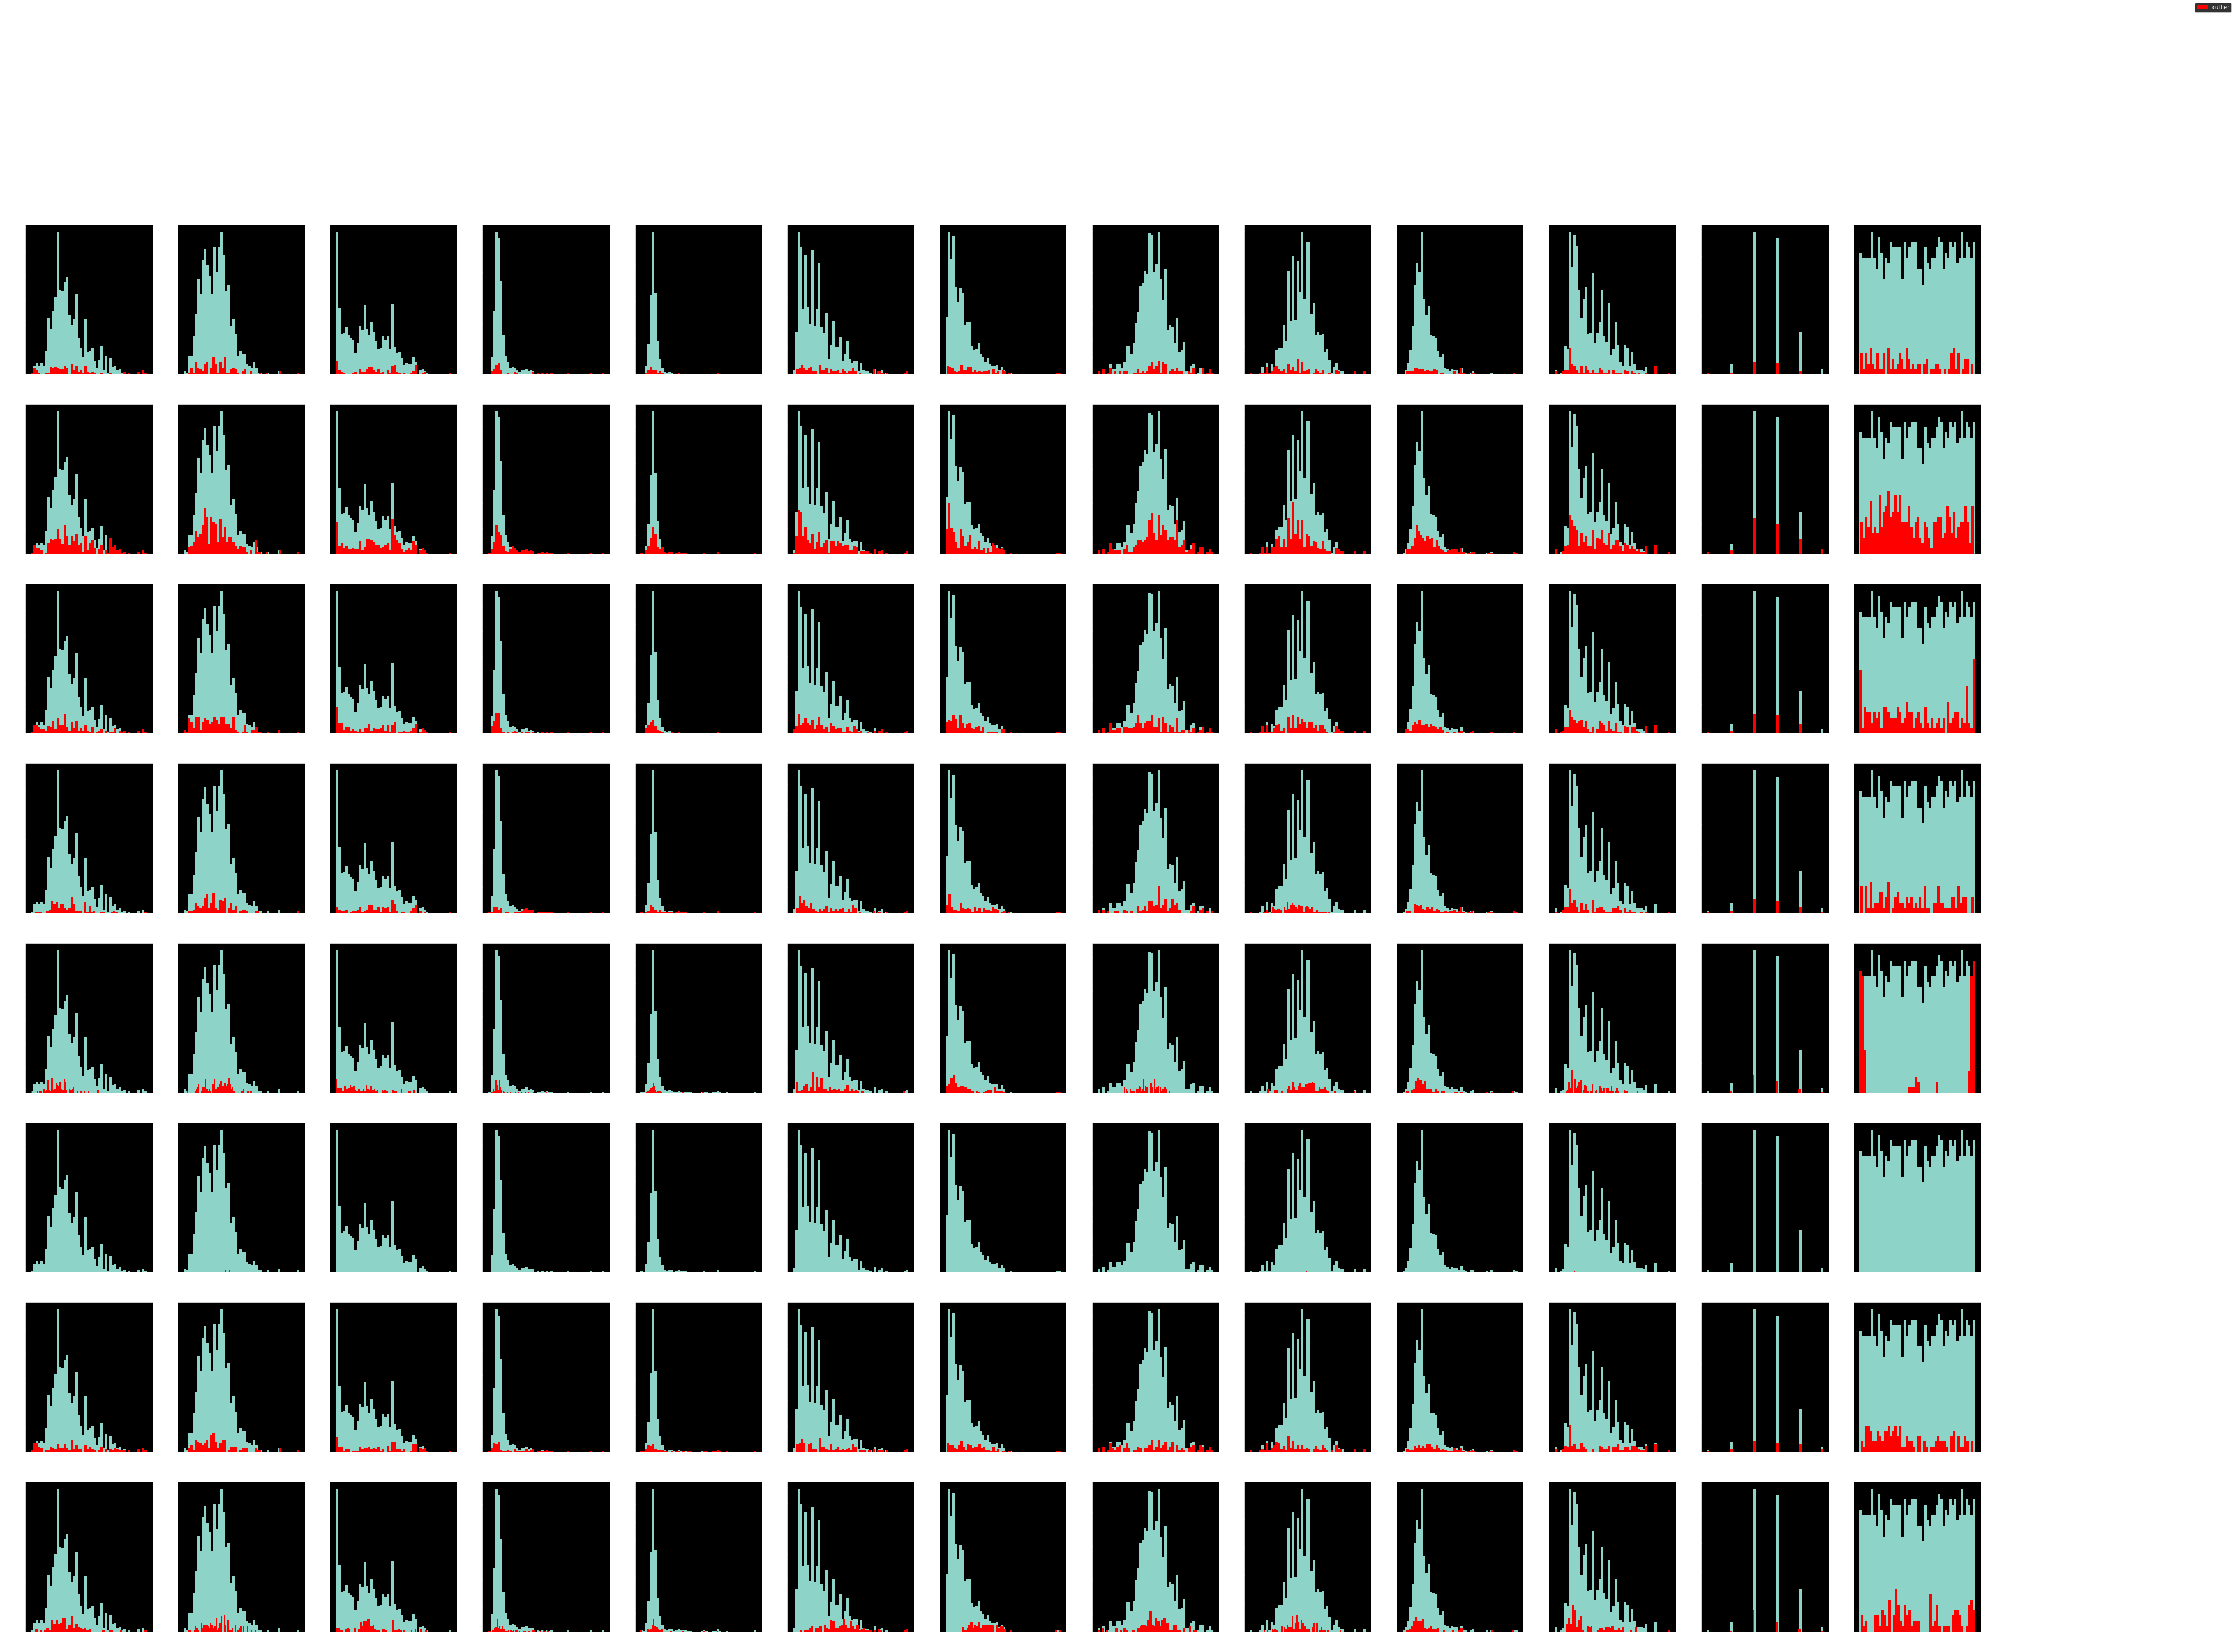

In [54]:
print('models used: ' + str(run_models))
for model in run_models:
    print(model + ' outliers: ' + str(len(run_models_data[model][0])))

if num_col == 1:
    fig, axs = plt.subplots(num_models, num_col, figsize=(plt_h*num_col, 2 * plt_v * num_models))
    fig.suptitle("Multivariate approaches results")
    for i, model in enumerate(run_models):
        model_outliers = run_models_data[model][0]
        axs[i].hist(df.iloc[model_outliers][df.columns[0]], color='r', bins = n_bins, zorder=2, label='outlier')
        axs[i].hist(df[df.columns[0]], bins = n_bins, zorder=1)
        axs[i].set_ylabel('Frequency')
        axs[i].set_title(model + ' outliers')
        axs[i].set_xlabel(df.columns[0])
elif num_col > 1:
    fig, axs = plt.subplots(num_models, num_col, figsize=(plt_h*num_col, plt_v * num_models))
    fig.suptitle("Multivariate approaches results")
    for i, model in enumerate(run_models):
        model_outliers = run_models_data[model][0]
        for j in range(num_col):
            axs[i][j].hist(df.iloc[model_outliers][df.columns[j]], color='r', bins = n_bins, zorder=2, label='outlier')
            axs[i][j].hist(df[df.columns[j]], bins = n_bins, zorder=1)
            axs[i][j].set_ylabel('Frequency')
            axs[i][j].set_title(model + ' outliers')
            axs[i][j].set_xlabel(df.columns[j])
        handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels)

## Outlier prediction

In [55]:
show_model = 'elliptic' # ['z_score', 'iqr', 'percentile', 'elliptic', 'svm', 'sgd_svm', 'iso', 'lof']

df_show = df.copy()
df_show['outlier'] = 0
outliers_show = run_models_data[show_model][0]
df_show.loc[df_show.index[outliers_show], 'outlier'] = 1
df_show

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1138            6.3             0.510         0.13             2.3      0.076   
1139            6.8             0.620         0.08             1.9      0.068   
1140            6.2             0.600         0.08             2.0      0.090   
1141            5.9             0.550         0.10             2.2      0.062   
1142            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1138                 29.0                  40.0  0.99574  3.42       0.75   
1139                 28.0                  38.0  0.99651  3.42       0.82   
1140                 32.0                  44.0  0.99490  3.45       0.58   
1141                 39.0                  51.0  0.99512  3.52       0.76   
1142                 32.0                  44.0  0.99547  3.57       0.71   

      alcohol  quality    Id  outlier  
0         9.4        5     0        0  
1         9.8        5     1        0  
2         9.8        5     2        0  
3         9.8        6     3        0  
4         9.4        5     4        0  
...       ...      ...   ...      ...  
1138     11.0        6  1592        0  
1139      9.5        6  1593        0  
1140     10.5        5  1594        0  
1141     11.2        6  1595        0  
1142     10.2        5  1597        0  

[1143 rows x 14 columns]

## Decision Boundary Visualisation
Only available for data with 2 features

In [56]:
if num_col == 2:
    xx_min = min(df[df.columns[0]])
    xx_max = max(df[df.columns[0]])
    xx_range = xx_max - xx_min
    yy_min = min(df[df.columns[1]])
    yy_max = max(df[df.columns[1]])
    yy_range = yy_max - yy_min
    xx, yy = np.meshgrid(np.linspace(xx_min - (yy_range), xx_max + (yy_range), 200), np.linspace(yy_min - (yy_range//2 + 1), yy_max + (yy_range//2 + 1), 200))
        
    fig, axs = plt.subplots(1, num_models, figsize=(plt_h*num_models, plt_v), sharex=True, sharey=True)
    fig.suptitle('Outlier Decision Boundaries')
    for i, model in enumerate(run_models):
        if model != 'lof':
            Z = run_models_data[model][1].predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            axs[i].contour(xx, yy, Z, levels=[0], linewidths=2, colors="red")
            y_pred = run_models_data[model][1].predict(df)
        else:
            Z = run_models_data[model][3].decision_function(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            axs[i].contour(xx, yy, Z, levels=[0], linewidths=2, colors="red")
            y_pred = run_models_data[model][1]
        colors = np.array(["#377eb8", "#ff7f00"])
        axs[i].scatter(df[df.columns[0]], df[df.columns[1]], s=10, color=colors[(y_pred + 1) // 2])
        axs[i].set_xlabel(df.columns[0])
        axs[i].set_ylabel(df.columns[1])
        axs[i].set_title(model + ' outliers')

elliptic approach


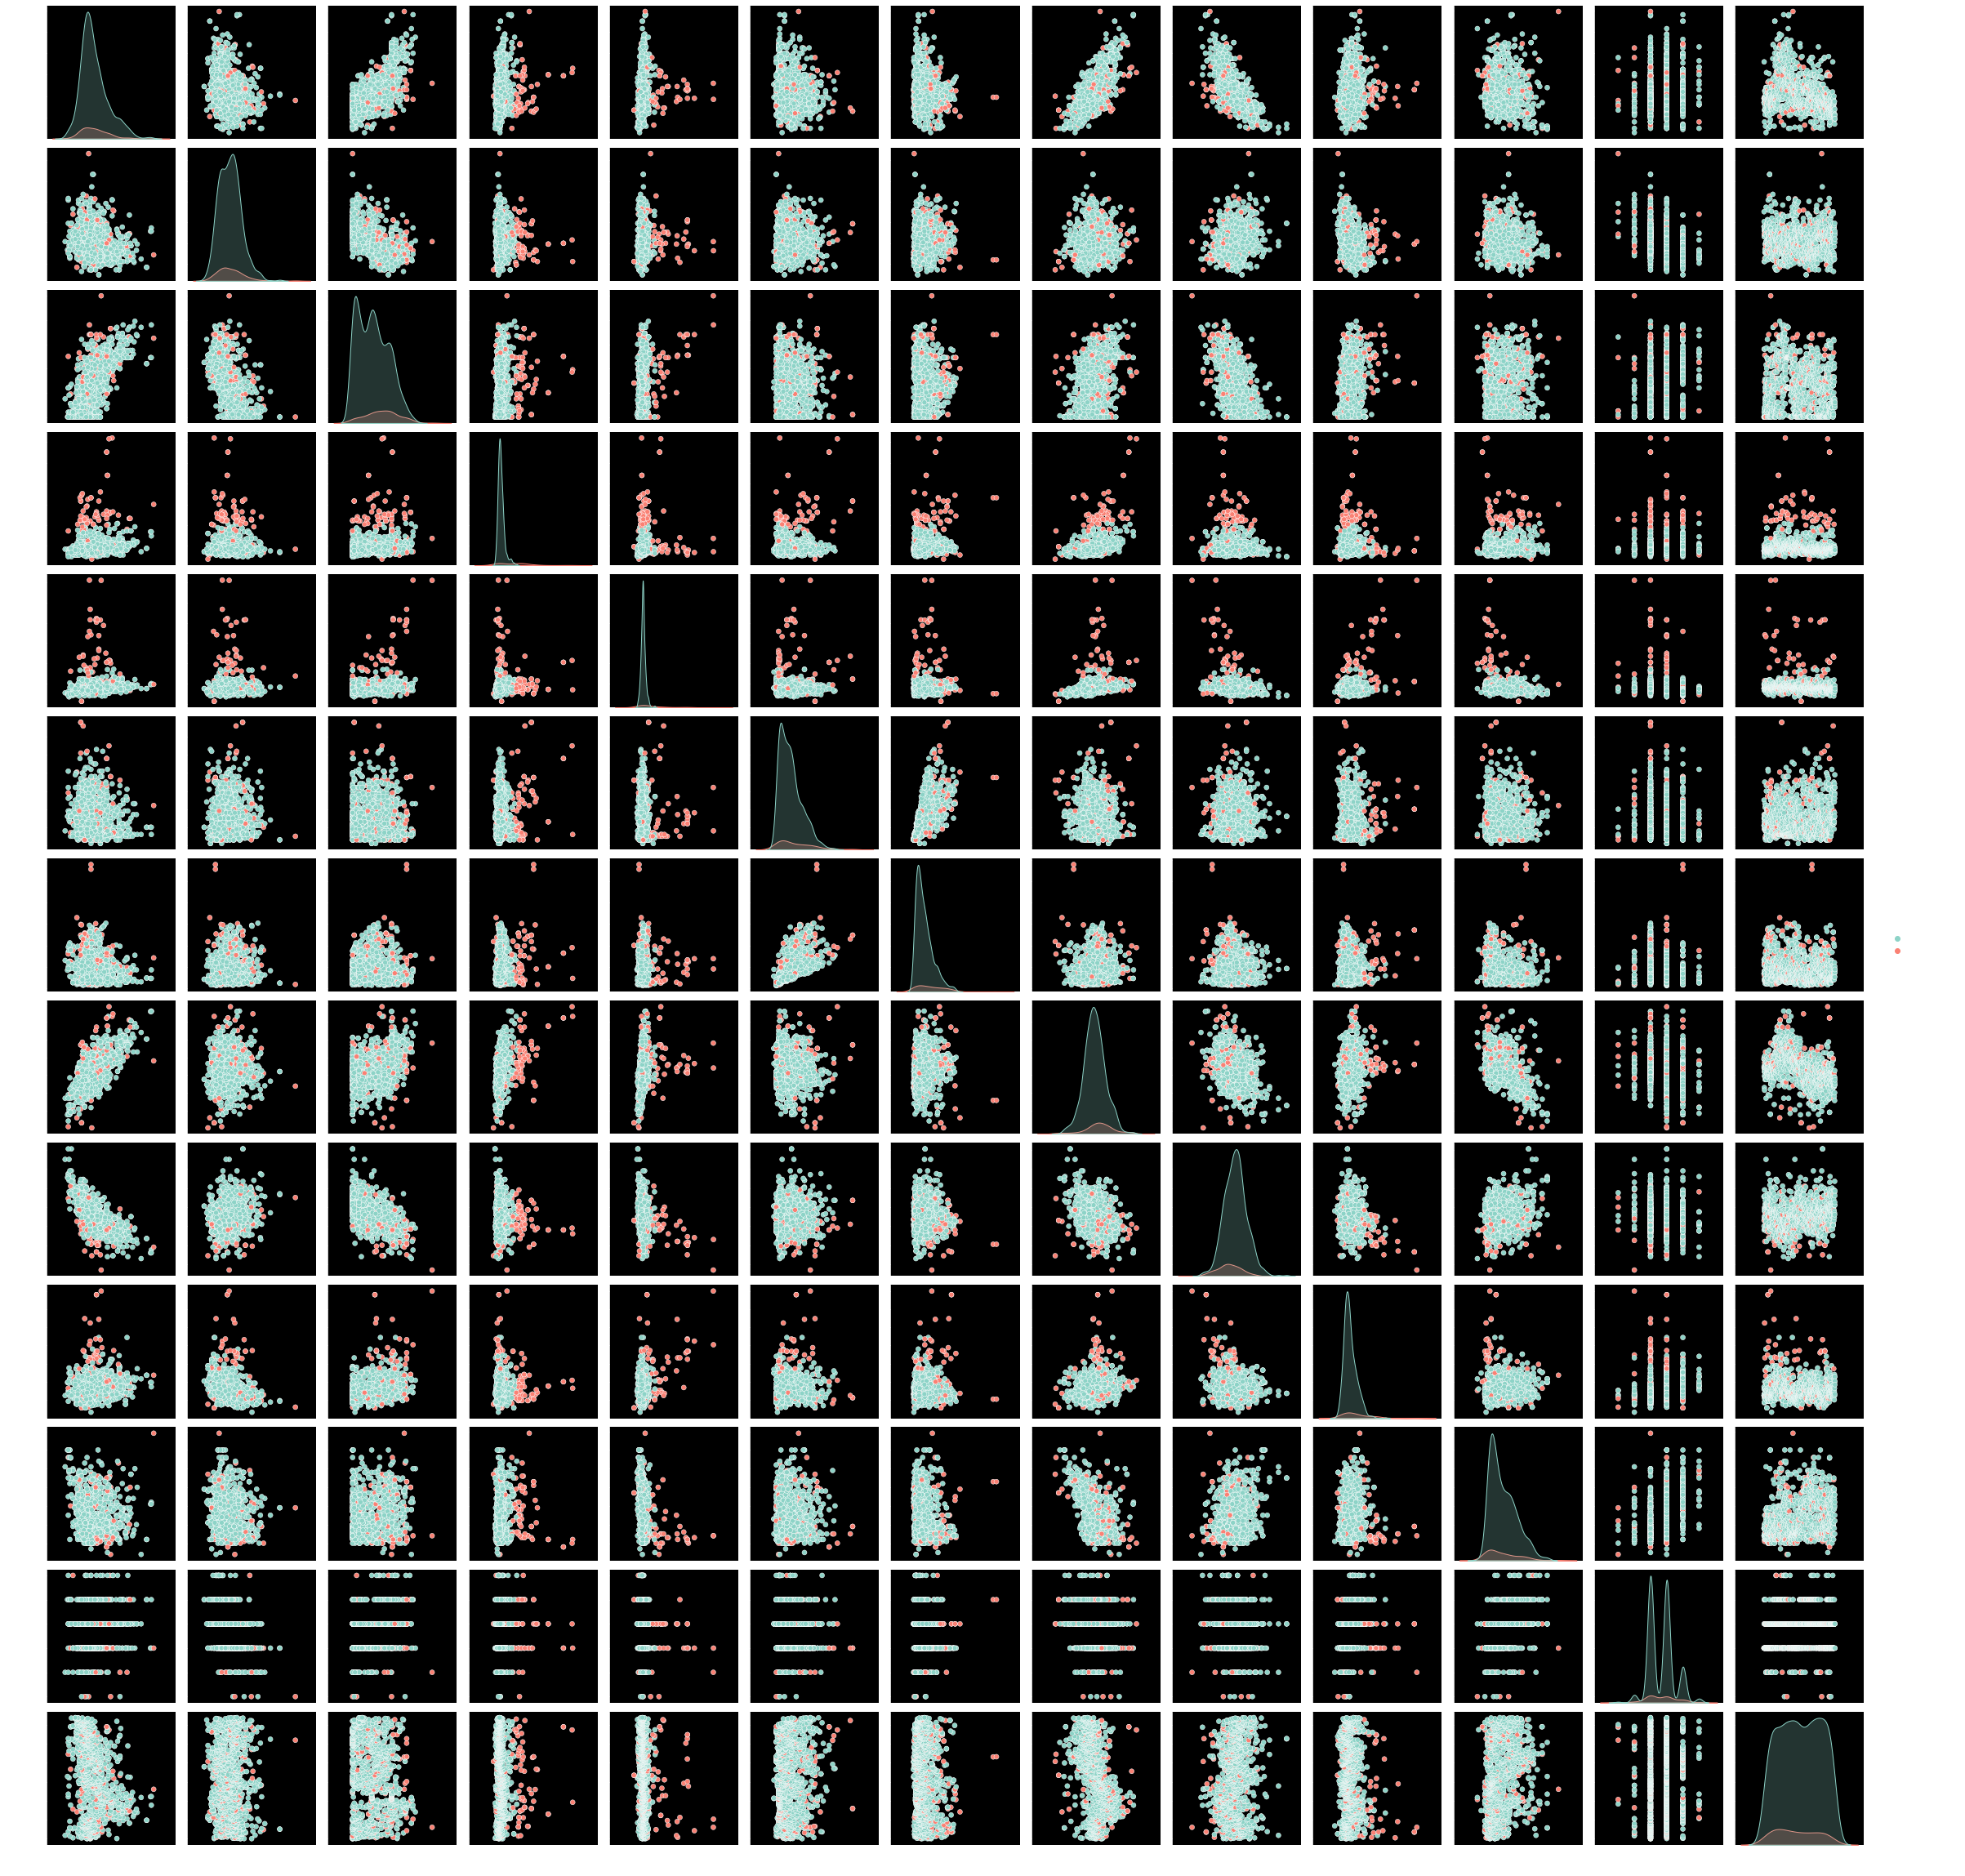

In [57]:
multi_approach_visual = 'elliptic' # 'elliptic', 'svm', 'sgd_svm', 'iso', or 'lof'
if multi_approach_visual == 'elliptic':
    out = run_models_data['elliptic'][0]
elif multi_approach_visual == 'svm':
    out = run_models_data['svm'][0]
elif multi_approach_visual == 'sgd_svm':
    out = run_models_data['sgd_svm'][0]
elif multi_approach_visual == 'iso':
    out = run_models_data['iso'][0]
elif multi_approach_visual == 'lof':
    out = run_models_data['lof'][0]

print(multi_approach_visual + ' approach')
df_multi_outlier = df.copy()
df_multi_outlier['outlier'] = 'Non Outlier'
df_multi_outlier.loc[df.index[out], 'outlier'] = 'Outlier'
palette ={"Non Outlier": "C0", "Outlier": "C3"}
sns.pairplot(df_multi_outlier, hue = 'outlier', palette=palette)

## Evaluation Metrics
### Clustering approaches
Silhouette Coefficient: Higher means better defined clusters. 
Calinski-Harabasz Index: Higher means better defined clusters.
Davies-Bouldin Index: Lower means better separation between clusters.

Note that clustering outlier detection evaluation may not reflect your use case. Eg if abnormal data is hidden in the clusters. 

In [58]:
multi_model_scores = {k:v[2] for (k, v) in run_models_data.items() if k not in ['z_score, iqr, percentile']}
multi_model_scores_df = pd.DataFrame(multi_model_scores, index = ['silhouette', 'calinski-harabasz', 'davies-bouldin'])
multi_model_scores_df

z_score        iqr  percentile   elliptic        svm  \
silhouette         0.015846   0.001619    0.055922   0.009752   0.290259   
calinski-harabasz  4.611158   4.200594    0.817216   3.134464   0.201789   
davies-bouldin     7.825629  12.696584   24.621166  10.069263  52.411394   

                    sgd_svm        iso        lof  
silhouette         0.176263   0.008404   0.017237  
calinski-harabasz  8.960596  11.789169   2.471884  
davies-bouldin     0.514287   5.052819  11.360470

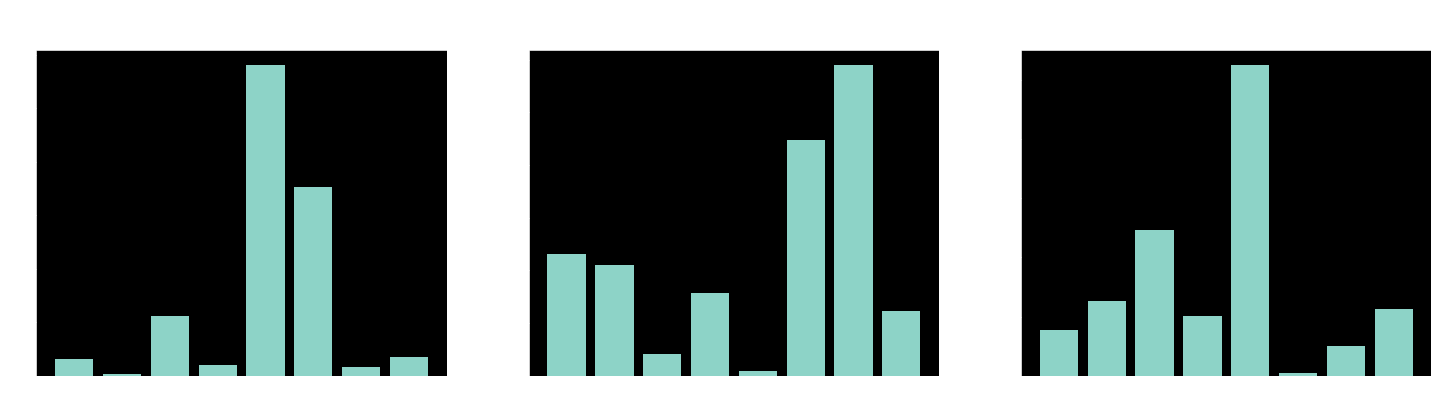

In [59]:
multi_model_scores = {k:v for (k, v) in multi_model_scores.items() if None not in v}
fig, axs = plt.subplots(1, 3, figsize=(plt_h*5, plt_v))
fig.suptitle('Unsupervised Clustering Metrics')
axs[0].bar([k for (k, v) in multi_model_scores.items()], [v[0] for (k, v) in multi_model_scores.items()])
axs[0].set_title('Silhouette - Higher: Better Defined Clusters')
axs[1].bar([k for (k, v) in multi_model_scores.items()], [v[1] for (k, v) in multi_model_scores.items()])
axs[1].set_title('Calinski-Harabasz - Higher: Better Defined Clusters')
axs[2].bar([k for (k, v) in multi_model_scores.items()], [v[2] for (k, v) in multi_model_scores.items()])
axs[2].set_title('Davies-Bouldin - Lower: Better Separated Clusters')
plt.show()

In [60]:
def export_outlier(df, model, export_path):
    df['outlier'] = 0
    outliers = run_models_data[model][0]
    df.loc[df.index[outliers], 'outlier'] = 1
    df.to_csv(export_path)


export_outlier(df, 'z_score', './../out/labeled_data')

In [61]:
# Exports the data
dump([run_models_data, df, time_series], './../out/unsupervised_model_data.joblib')

['./../out/unsupervised_model_data.joblib']